# Introduction/Business Problem
The COVID-19 pandemic has taken an unprecedented toll globally, already affecting over 2M people, taking over 200K lives and, according to WEF, will likely cost the world 2 trillion USD in economic losses.

In the Philippines, the responsibility of managing the quarantine falls on the shoulders of the mayors of the cities and municipalities.

Not all cities are affected by the virus the same way. Some cities are overwhelmed by the number of cases. Some cities have seen the peak and are now slowly coming down in terms of cases. Some cities are growing in terms of the number of cases.

The mayors will be interested to see where their city is relative to cases. Is their city on the downward path or in the growth path?

The citizens, on the other hand, will be interested to know where the hospitals are near their location.

This is the problem we want to solve with data analysis.

As an application, we would have an interface for mayors to see if their daily rates of cases are growing or decreasing.

For citizens, they can find out the nearest health facilities and testing centers are so they can go there in case they need to be tested or see a healthcare professional.

# Data Section
For this exercise, we will be using the following datasets:

1. Case Information dataset provided by the Philippine Department of Health. We will use this dataset to determine the growth rates per city. This dataset includes the following fields:
	* CaseCode : Random code assigned for labelling cases
	* Age : Age
	* AgeGroup : Five-year age group
	* Sex : Sex
	* DateRepConf : Date publicly announced as confirmed case
	* DateRecover : Date recovered
	* DateDied : Date died
	* RemovalType : Type of removal (recovery or death)
	* DateRepRem : Date publicly announced as removed
	* Admitted : Binary variable indicating patient has been admitted to hospital
	* RegionRes : Region of residence
	* ProvCityRes : Province of residence
	* RegionPSGC : Philippine Standard Geographic Code of Region of Residence
	* ProvPSGC : Philippine Standard Geographic Code of Province of Residence
	* MunCityPSGC : Philippine Standard Geographic Code of Municipality or City of Residence
	* HealthStatus : Known current health status of patient (asymptomatic, mild, severe, critical, died, recovered)
	* Quarantined : Ever been home quarantined, not necessarily currently in home quarantine
2. Geojson dataset of cities and municipalities in the Philippines. We will use this dataset to provide the mapping boundaries of the different cities and municipalities in the Philippines.
	* ID_0 : Unique ID 0
	* ISO : ISO Country Code
	* NAME_0 : Country Name
	* NAME_2 : Municipality or City Name
	* PROVINCE : Province Name
	* REGION : Regiona Name
	* geometry : Polygon, coordinates
3. Foursquare Search API. We will use this dataset to provide us with with information of health related venues especially their location expressed in latitudes and longitudes. We will also use the categories as a filter. We will bash this data with the boundaries provided by the city geojson dataset above. The Foursquare Search API returns the following data:
	* id : A unique string identifier for this venue.
	* name : The best known name for this venue.
	* location : An object containing none, some, or all of address (street address), crossStreet, city, state, postalCode, country, lat, lng, and distance. All fields are strings, except for lat, lng, and distance. Distance is measured in meters. Some venues have their locations intentionally hidden for privacy reasons (such as private residences). If this is the case, the parameter isFuzzed will be set to true, and the lat/lng parameters will have reduced precision.
	* categories : An array, possibly empty, of categories that have been applied to this venue. One of the categories will have a primary field indicating that it is the primary category for the venue. For the complete category tree, see categories.

# Methodology
section which represents the main component of the report where you discuss and describe any exploratory data analysis that you did, any inferential statistical testing that you performed, if any, and what machine learnings were used and why.

We will use the CRISP-DM (Cross-Industry Process for Data Mining) methodology. The CRISP-DM methodology is well-proven methodology in data science. CRISP-DM loosely and iteratively follows six major phases:

1. Business Understanding
2. Data Understanding
3. Data Preparation
4. Modeling
5. Evaluation
6. Deployment

As we have have covered #1 and #2 previously, we will continue with Data Preparation.

## Data Preparation

### Loading Data

1. We start by importing all necessary libraries and installing all dependencies for the project.

## plan

- [Setup](#setup)
    - import libraries
- [Prepare data](#data_prep)
    - DOH data
        - explore
        - clean
        - select
    - Poverty data
        - explore
        - clean
        - select
    - City index data
        - explore
        - clean
        - select
    - City Latlong
        - load json
        - explore
        - clean
        - select
    - Merge data
        - calculate case/pop as predicted variable
        - calculate distance from manila as additional feature
- Predict
- Visualize

<a name="setup"></a>
### Setup

<a name="import_lib"></a>
#### Import libraries

In [1]:
import numpy as np
import pandas as pd
import json5 as json # library to handle JSON files
import requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import matplotlib.cm as cm
import matplotlib.colors as colors
import folium # map rendering library
import seaborn as sns

#prep
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, MaxAbsScaler, QuantileTransformer

#models
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, LinearRegression, Ridge, RidgeCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

#validation libraries
from sklearn.model_selection import KFold, StratifiedKFold
from IPython.display import display
from sklearn import metrics



print('Libraries imported.')

Libraries imported.


<a name='data_prep'></a>
### Data Preparation

#### DOH Data

1. We define the columns and their proper data types.

In [2]:
#define column types
col_types = {'Age' : 'float64', 
             'AgeGroup' : 'category', 
             'Sex' : 'category', 
             'RemovalType' : 'category', 
             'Admitted' : 'category', 
             'RegionRes' : 'category', 
             'ProvRes' : 'category', 
             'CityMunRes' : 'category', 
             'CityMuniPSGC' : 'category',
             'BarangayRes' : 'category',
             'BarangayPSGC' : 'category',
             'HealthStatus' : 'category', 
             'Quarantined' : 'category', 
             'Pregnanttab' : 'category', 
             'ValidationStatus' : 'category'}
col_date = [4, 5, 6, 7, 8, 19]

3. We read the csv and load it into a data frame.

In [3]:
df = pd.read_csv("DOH COVID Data Drop_ 20201013 - 04 Case Information.csv", dtype = col_types, parse_dates = col_date)

##### Exploratory Data Analysis
1. We do a quick check on the dataframe

In [4]:
#check our dataframe
df.info()
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344713 entries, 0 to 344712
Data columns (total 22 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   CaseCode           344713 non-null  object        
 1   Age                342504 non-null  float64       
 2   AgeGroup           342504 non-null  category      
 3   Sex                344713 non-null  category      
 4   DateSpecimen       296568 non-null  datetime64[ns]
 5   DateResultRelease  298652 non-null  datetime64[ns]
 6   DateRepConf        344713 non-null  datetime64[ns]
 7   DateDied           6334 non-null    datetime64[ns]
 8   DateRecover        74015 non-null   datetime64[ns]
 9   RemovalType        299755 non-null  category      
 10  Admitted           344559 non-null  category      
 11  RegionRes          340934 non-null  category      
 12  ProvRes            319787 non-null  category      
 13  CityMunRes         309212 non-null  category

,CaseCode,Age,AgeGroup,Sex,DateSpecimen,DateResultRelease,DateRepConf,DateDied,DateRecover,RemovalType,...,ProvRes,CityMunRes,CityMuniPSGC,BarangayRes,BarangayPSGC,HealthStatus,Quarantined,DateOnset,Pregnanttab,ValidationStatus
0,C900280,35.0,35 to 39,MALE,2020-07-03,2020-07-29,2020-08-05,NaT,NaT,RECOVERED,...,CAVITE,IMUS CITY,PH042109000,NaN,NaN,RECOVERED,NO,NaT,NaN,"Removal Type is ""Recovered"", but no Recovered ..."
1,C778257,32.0,30 to 34,FEMALE,2020-07-15,2020-07-17,2020-07-20,NaT,NaT,RECOVERED,...,COTABATO CITY (NOT A PROVINCE),NaN,NaN,NaN,NaN,RECOVERED,NO,NaT,NO,"Removal Type is ""Recovered"", but no Recovered ..."
2,C778303,54.0,50 to 54,MALE,2020-07-24,2020-07-29,2020-08-02,NaT,NaT,RECOVERED,...,NCR,CITY OF MANILA,PH133901000,NaN,NaN,RECOVERED,NO,NaT,NaN,"Health Status is ""Recovered"", but no Date Reco..."
3,C928860,33.0,30 to 34,MALE,NaT,NaT,2020-06-01,NaT,NaT,RECOVERED,...,NaN,NaN,NaN,NaN,NaN,RECOVERED,YES,NaT,NaN,"Health Status is ""Recovered"", but no Date Reco..."
4,C620602,1.0,0 to 4,FEMALE,2020-07-13,2020-07-16,2020-07-30,NaT,2020-07-30,RECOVERED,...,NCR,NaN,NaN,NaN,NaN,RECOVERED,NO,NaT,NO,NaN


In [5]:
#determine unique values per column
df.nunique(axis=0)

CaseCode             344713
Age                     104
AgeGroup                 17
Sex                       2
DateSpecimen            225
DateResultRelease       224
DateRepConf             225
DateDied                217
DateRecover             223
RemovalType               2
Admitted                  2
RegionRes                18
ProvRes                  84
CityMunRes             1360
CityMuniPSGC           1561
BarangayRes            8784
BarangayPSGC          12338
HealthStatus              6
Quarantined               2
DateOnset               227
Pregnanttab               2
ValidationStatus        502
dtype: int64

2. Since our study wants to see if certain city statistic predicts cases, we will limit our variables to cases and cities, i.e CityMuniPSGC

In [6]:
df1 = df

In [7]:
df1 = df1[['CaseCode','DateRepConf','CityMuniPSGC']]

3. We drop the rows where we can't identify the cities

In [8]:
#drop Nan cities
df1 = df1.loc[-df1.CityMuniPSGC.isna(),:]

4. For consistency, we rename CityMuniPSGC column to PSGC, which stands for Philippine Standard Geographic Code.

In [9]:
df1 = df1.rename(columns={"CityMuniPSGC": "PSGC"})

5. Then we group the dataframe into cities are represented by PSGC and count the cases.

In [10]:
df_cases_by_city = df1.groupby(['PSGC'])['CaseCode'].count().reset_index()

6. Then we transform PSGC to standard nine-digit code for consistency

In [11]:
df_cases_by_city.PSGC = df_cases_by_city.PSGC.str.replace('PH','')
df_cases_by_city.rename(columns={"CaseCode": "Cases"}, inplace = True)
df_cases_by_city.sort_values('PSGC', inplace = True)
df_cases_by_city.set_index('PSGC', inplace = True)
#check
df_cases_by_city.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1561 entries, 012802000 to 175917000
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Cases   1561 non-null   int64
dtypes: int64(1)
memory usage: 24.4+ KB


### Poverty data

In [12]:
#read city stats
df2 = pd.read_csv('City and Municipal-level Small Area Poverty Estimates_ 2009, 2012 and 2015_0.csv',
                  skiprows = [0,1,2,3,4],
                  encoding = "ISO-8859-1",
                  names = ['PSGC_ID','Poverty Incidence'],
                  usecols = [0,5],
                  dtype = {'PSGC_ID':'object','Poverty Incidence':np.float16})

In [13]:
#drop NaN indexes
df2 = df2.loc[df2.index.dropna()]

In [14]:
#drop other invalid rows
df2 = df2.loc[-df2.PSGC_ID.isna()]

In [15]:
df2['PSGC'] = df2.PSGC_ID.str.zfill(6)
df2['PSGC'] = df2.PSGC.str.ljust(9, '0')
df2.sort_values('PSGC', inplace = True)
df2.drop('PSGC_ID', axis =1, inplace = True)
df2.set_index('PSGC', inplace = True)
df2.sort_index(inplace = True)
#check
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1644 entries, 012801000 to 175917000
Data columns (total 1 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Poverty Incidence  1644 non-null   float16
dtypes: float16(1)
memory usage: 16.1+ KB


### City index data

In [16]:
#load city data
df3 = pd.read_excel('PSGC 2Q 2020 Publication.xlsx',
                    sheet_name = 'PSGC',
                    usecols = [i for i in range(7)],
                    names = ['PSGC',
                             'Name',
                             'Geographic Level',
                             'City Class',
                             'Income Classification',
                             'Urban Rural',
                             'Population'])

In [17]:
#filter to only include cities, municipalities and sub municipalities
df3 = df3[df3['Geographic Level'].isin(['City','Mun','SubMun'])]

In [18]:
#replace NaNs with UNK
df3 = df3.fillna('UNK')

In [19]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1648 entries, 2 to 43788
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   PSGC                   1648 non-null   int64 
 1   Name                   1648 non-null   object
 2   Geographic Level       1648 non-null   object
 3   City Class             1648 non-null   object
 4   Income Classification  1648 non-null   object
 5   Urban Rural            1648 non-null   object
 6   Population             1648 non-null   int64 
dtypes: int64(2), object(5)
memory usage: 103.0+ KB


In [20]:
df3.nunique()

PSGC                     1648
Name                     1445
Geographic Level            3
City Class                  4
Income Classification      17
Urban Rural                 1
Population               1636
dtype: int64

In [21]:
df3['Geographic Level'].unique()

array(['Mun', 'City', 'SubMun'], dtype=object)

In [22]:
df3['City Class'].unique()

array(['UNK', 'CC', 'ICC', 'HUC'], dtype=object)

In [23]:
df3['Income Classification'].unique()

array(['5th', '3rd', '4th', '2nd', '1st', '6th', '1st (as Mun)', '3rd*',
       '4th*', '5th*', '1st*', '2nd*', '6th*', '1st* (reclass 2005)',
       'Special', 'UNK', '-'], dtype=object)

In [24]:
df3['Urban Rural'].unique()

array(['UNK'], dtype=object)

In [25]:
df3['Income Classification'] = df3['Income Classification'].str.replace(r'\*.*','')

In [26]:
df3['Income Classification'] = df3['Income Classification'].str.replace(r' .*','')

In [27]:
df3['Income Classification'] = df3['Income Classification'].str.replace('-','UNK')

In [28]:
df3.drop('Urban Rural', axis =1, inplace = True)

In [29]:
df3.PSGC = df3.PSGC.astype('str')

In [30]:
df3.PSGC = df3.PSGC.str.zfill(9)

In [31]:
df3 = df3.astype(dtype = {'PSGC':'category', 'Name':'category',
                    'Geographic Level':'category',
                    'City Class':'category',
                    'Income Classification':'category'})

In [32]:
df3.sort_values('PSGC', inplace = True)

In [33]:
df3.set_index('PSGC', inplace = True)

In [34]:
df3.sort_index(inplace = True)

In [35]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
CategoricalIndex: 1648 entries, 012801000 to 175917000
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   Name                   1648 non-null   category
 1   Geographic Level       1648 non-null   category
 2   City Class             1648 non-null   category
 3   Income Classification  1648 non-null   category
 4   Population             1648 non-null   int64   
dtypes: category(4), int64(1)
memory usage: 169.0 KB


In [36]:
df3.head()

,Name,Geographic Level,City Class,Income Classification,Population
PSGC,,,,,
012801000,ADAMS,Mun,UNK,5th,1792
012802000,BACARRA,Mun,UNK,3rd,32215
012803000,BADOC,Mun,UNK,3rd,31616
012804000,BANGUI,Mun,UNK,4th,14672
012805000,CITY OF BATAC,City,CC,5th,55201


### Merge data

In [37]:
df4 = df_cases_by_city

In [38]:
df4 = df4.merge(df3, how = 'left', left_index=True, right_index=True)

In [39]:
df4 = df4.merge(df2, how = 'left', left_index=True, right_index=True)

In [40]:
df4

,Cases,Name,Geographic Level,City Class,Income Classification,Population,Poverty Incidence
PSGC,,,,,,,
012802000,4,BACARRA,Mun,UNK,3rd,32215.0,7.500000
012803000,8,BADOC,Mun,UNK,3rd,31616.0,10.703125
012804000,7,BANGUI,Mun,UNK,4th,14672.0,8.500000
012805000,16,CITY OF BATAC,City,CC,5th,55201.0,7.800781
012806000,4,BURGOS,Mun,UNK,5th,9777.0,8.398438
...,...,...,...,...,...,...,...
175913000,13,SAN FERNANDO,Mun,UNK,4th,23271.0,37.687500
175914000,1,SAN JOSE,Mun,UNK,5th,10881.0,33.906250
175915000,1,SANTA FE,Mun,UNK,5th,16098.0,32.687500


#### calculate case/pop as predicted variable
calculate distance from manila as additional feature

In [41]:
df4['Case Per Capita'] = df4.Cases/df4.Population

In [42]:
df4.dropna(axis=0, how='any', thresh=None, subset=None, inplace=True)

In [43]:
df4.shape

(1556, 8)

### Exploratory Data Analysis
So now we have a dataset of cities and municipalities with feature statistics like city class, income classification, population and poverty incidences as possible predictors of cases per capita.

In [44]:
df4.sort_values('Case Per Capita', ascending = False)

,Cases,Name,Geographic Level,City Class,Income Classification,Population,Poverty Incidence,Case Per Capita
PSGC,,,,,,,,
133908000,542,ERMITA,SubMun,UNK,UNK,10523.0,5.300781,0.051506
133902000,547,BINONDO,SubMun,UNK,UNK,18040.0,3.500000,0.030322
137405000,3211,CITY OF SAN JUAN,City,HUC,1st,122180.0,2.400391,0.026281
137606000,1668,PATEROS,Mun,UNK,1st,63840.0,2.500000,0.026128
133909000,129,INTRAMUROS,SubMun,UNK,UNK,5935.0,10.203125,0.021735
...,...,...,...,...,...,...,...,...
097206000,1,LILOY,Mun,UNK,3rd,39812.0,38.187500,0.000025
012924000,1,SANTA CRUZ,Mun,UNK,1st,39868.0,14.703125,0.000025
156613000,2,TALIPAO,Mun,UNK,1st,80255.0,58.093750,0.000025


In [92]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1556 entries, 012802000 to 175917000
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   Cases                  1556 non-null   int64   
 1   Name                   1556 non-null   category
 2   Geographic Level       1556 non-null   category
 3   City Class             1556 non-null   category
 4   Income Classification  1556 non-null   category
 5   Population             1556 non-null   float64 
 6   Poverty Incidence      1556 non-null   float16 
 7   Case Per Capita        1556 non-null   float64 
dtypes: category(4), float16(1), float64(2), int64(1)
memory usage: 151.2+ KB


Since we have explicitly changed NaNs to literal UNK categorical values, it would be worth checking how many UNKs are there.

In [102]:
#change UNK for different columns
for columns in df4.columns:
    print(f'Percent UNK Column {columns} = {((sum(df4[columns] == "UNK"))/len(df4[columns])):.0%}')

Percent UNK Column Cases = 0%
Percent UNK Column Name = 0%
Percent UNK Column Geographic Level = 0%
Percent UNK Column City Class = 91%
Percent UNK Column Income Classification = 2%
Percent UNK Column Population = 0%
Percent UNK Column Poverty Incidence = 0%
Percent UNK Column Case Per Capita = 0%


This points to feature City Class to have mostly UNKs so let's get that off our list of features.

In [108]:
df5 = df4[['Geographic Level','Income Classification',
           'Population','Poverty Incidence','Case Per Capita']]

In [109]:
df5.head()

,Geographic Level,Income Classification,Population,Poverty Incidence,Case Per Capita
PSGC,,,,,
012802000,Mun,3rd,32215.0,7.500000,0.000124
012803000,Mun,3rd,31616.0,10.703125,0.000253
012804000,Mun,4th,14672.0,8.500000,0.000477
012805000,City,5th,55201.0,7.800781,0.000290
012806000,Mun,5th,9777.0,8.398438,0.000409


1. Doing pairplots and correlattion analysis shows that of the features mentioned above, none is a strong predictor.

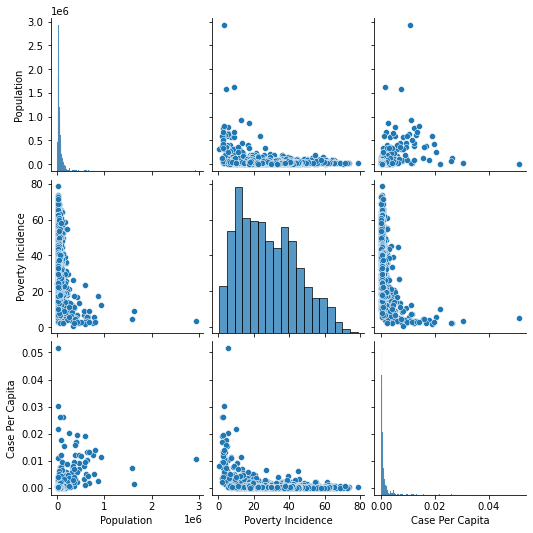

In [110]:
sns.pairplot(df5)

<AxesSubplot:>

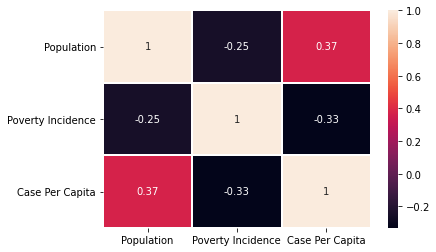

In [111]:
sns.heatmap(df5.corr(),annot=True,lw=1)

In [112]:
df5.corr()

,Population,Poverty Incidence,Case Per Capita
Population,1.000000,-0.251087,0.373694
Poverty Incidence,-0.251087,1.000000,-0.330801
Case Per Capita,0.373694,-0.330801,1.000000


2. Separating the analysis by geographic level shows correlation to be stronger at City level.

In [113]:
df5.head()

,Geographic Level,Income Classification,Population,Poverty Incidence,Case Per Capita
PSGC,,,,,
012802000,Mun,3rd,32215.0,7.500000,0.000124
012803000,Mun,3rd,31616.0,10.703125,0.000253
012804000,Mun,4th,14672.0,8.500000,0.000477
012805000,City,5th,55201.0,7.800781,0.000290
012806000,Mun,5th,9777.0,8.398438,0.000409


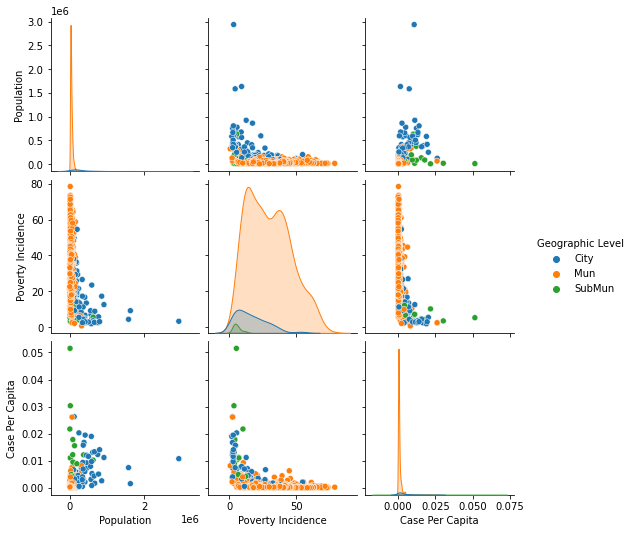

In [114]:
sns.pairplot(df5, hue = "Geographic Level")

/Users/gio/opt/anaconda3/envs/Coursera/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/gio/opt/anaconda3/envs/Coursera/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/gio/opt/anaconda3/envs/Coursera/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


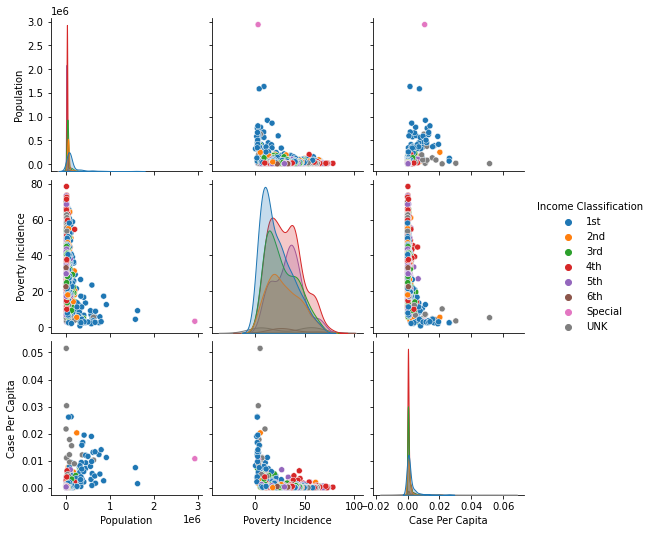

In [115]:
sns.pairplot(df5, hue = "Income Classification")

In [91]:
df5 = df4[['Geographic Level', 'City Class',
       'Income Classification', 'Population', 'Poverty Incidence',
       'Case Per Capita']]

Index(['Cases', 'Name', 'Geographic Level', 'City Class',
       'Income Classification', 'Population', 'Poverty Incidence',
       'Case Per Capita'],
      dtype='object')

In [84]:
feature_to_remove = 'Geographic Level'

In [85]:
sub_df = df4

In [89]:
col_list_new = list(sub_df.columns)
col_list_new

['Cases',
 'Name',
 'Geographic Level',
 'City Class',
 'Income Classification',
 'Population',
 'Poverty Incidence',
 'Case Per Capita']

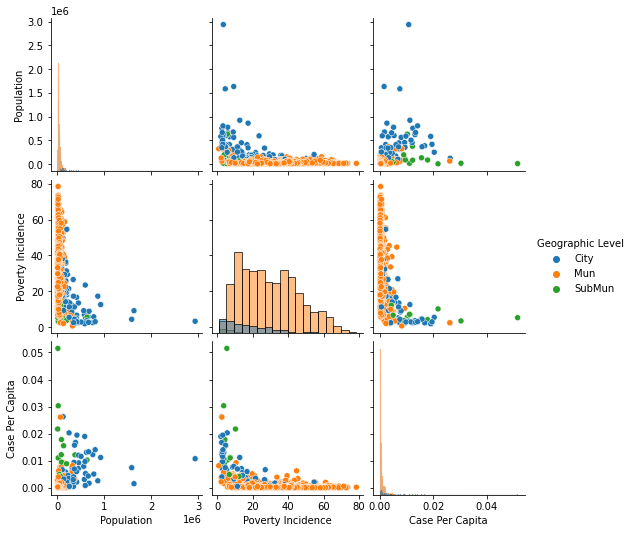

In [48]:
sns.pairplot(df4[['Geographic Level','Population','Poverty Incidence','Case Per Capita']], hue = 'Geographic Level',
            diag_kind="hist")

In [83]:
geo_levels = df4['Geographic Level'].unique()
geo_levels

['Mun', 'City', 'SubMun']
Categories (3, object): ['Mun', 'City', 'SubMun']

In [ ]:
for level in geo_levels:
    sub_df = df4.loc[df4['Geographic Level'] == level,['Population', 'Poverty Incidence','Case Per Capita']]
    print(level)
    print('\n')
    #print(sub_df.corr().loc['Case Per Capita'])
    sns.pairplot(sub_df)
    print('\n\n')

In [ ]:
def corr_by_level(dataframe, variable):
    for level in geo_levels:
        sub_df = df4.loc[df4['Geographic Level'] == level,['Population', 'Poverty Incidence','Case Per Capita']]
    print(level)
    print('\n')
    #print(sub_df.corr().loc['Case Per Capita'])
    sns.pairplot(sub_df)
    print('\n\n')

In [ ]:
for level in geo_levels:
    sub_df = df4.loc[df4['Geographic Level'] == level,['Population', 'Poverty Incidence','Case Per Capita']]
    print(level)
    print('\n')
    #print(sub_df.corr().loc['Case Per Capita'])
    sns.pairplot(sub_df)
    print('\n\n')

In [50]:
df4.columns

Index(['Cases', 'Name', 'Geographic Level', 'City Class',
       'Income Classification', 'Population', 'Poverty Incidence',
       'Case Per Capita'],
      dtype='object')

In [51]:
df4['Geographic Level'].unique()

['Mun', 'City', 'SubMun']
Categories (3, object): ['Mun', 'City', 'SubMun']

In [52]:
df4.loc[df4['Geographic Level'] == 'Mun',['Population', 'Poverty Incidence']]

,Population,Poverty Incidence
PSGC,,
012802000,32215.0,7.500000
012803000,31616.0,10.703125
012804000,14672.0,8.500000
012806000,9777.0,8.398438
012808000,12184.0,9.296875
...,...,...
175913000,23271.0,37.687500
175914000,10881.0,33.906250
175915000,16098.0,32.687500


Mun





City





SubMun







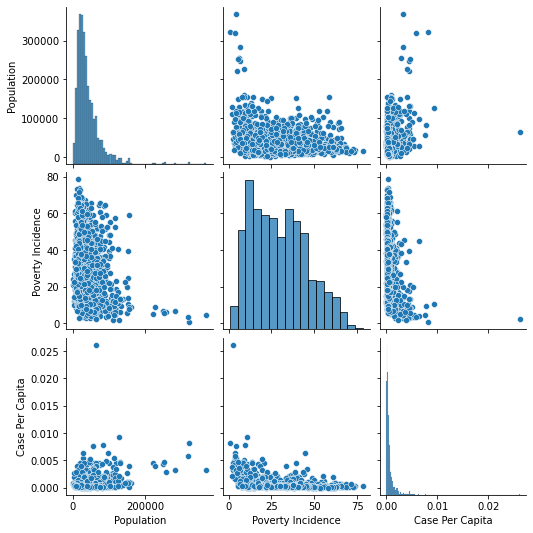

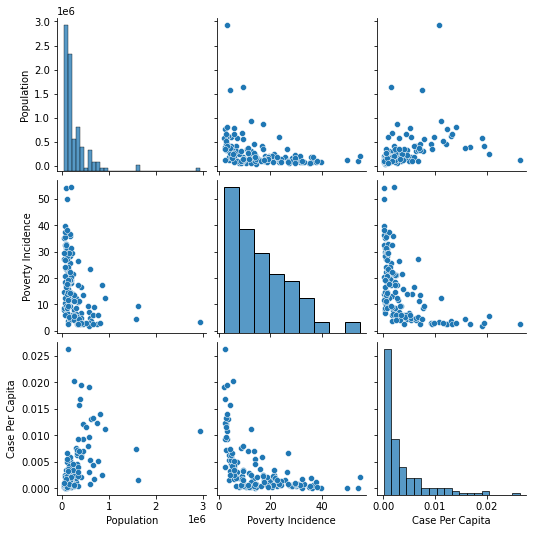

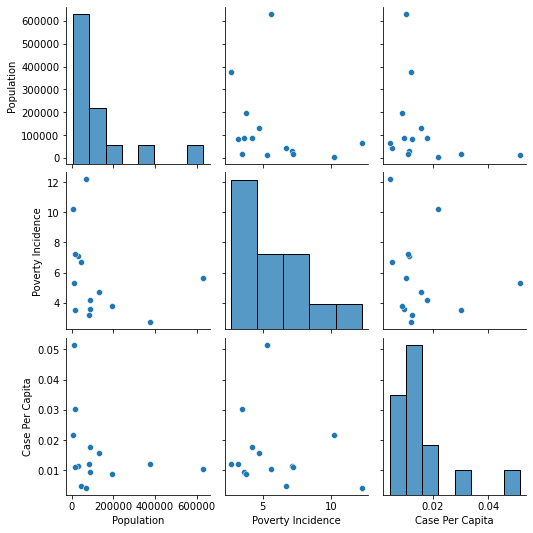

In [53]:
for level in df4['Geographic Level'].unique():
    sub_df = df4.loc[df4['Geographic Level'] == level,['Population', 'Poverty Incidence','Case Per Capita']]
    print(level)
    print('\n')
    #print(sub_df.corr().loc['Case Per Capita'])
    sns.pairplot(sub_df)
    print('\n\n')

In [54]:
df4['Income Classification'].unique()

['3rd', '4th', '5th', '2nd', '1st', '6th', 'UNK', 'Special']
Categories (8, object): ['3rd', '4th', '5th', '2nd', '1st', '6th', 'UNK', 'Special']

In [55]:
#dummy variables

#change UNK for different columns
for columns in df4.columns:
    print(f'Number of Unknowns for Column {columns} = {sum(df4[columns] == "UNK")}')

Number of Unknowns for Column Cases = 0
Number of Unknowns for Column Name = 0
Number of Unknowns for Column Geographic Level = 0
Number of Unknowns for Column City Class = 1413
Number of Unknowns for Column Income Classification = 30
Number of Unknowns for Column Population = 0
Number of Unknowns for Column Poverty Incidence = 0
Number of Unknowns for Column Case Per Capita = 0


In [56]:
df5 = pd.get_dummies(df4, 
               columns = ['Geographic Level', 'Income Classification'], 
               prefix = ['GL','IC'])

In [57]:
df5 = df5[['Name', 'Population', 'Poverty Incidence', 'GL_City', 
     'GL_Mun', 'GL_SubMun', 'IC_1st', 'IC_2nd','IC_3rd', 'IC_4th', 
     'IC_5th', 'IC_6th', 'IC_Special', 'IC_UNK','Case Per Capita']]

<AxesSubplot:>

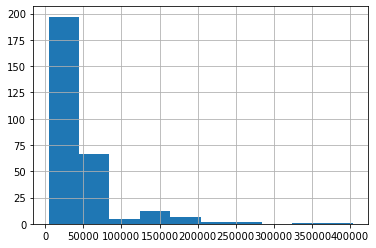

In [58]:
#check histogram of population
df5['Population'][df5['IC_3rd'] == 1].hist()

In [59]:
#normalize population\
ss = StandardScaler()
df5['Population Normalized'] = ss.fit_transform(df5[['Population']])

In [60]:
df5.corr().loc['Case Per Capita']

Population               0.373694
Poverty Incidence       -0.330801
GL_City                  0.289013
GL_Mun                  -0.441091
GL_SubMun                0.522756
IC_1st                   0.152971
IC_2nd                  -0.036701
IC_3rd                  -0.070867
IC_4th                  -0.101690
IC_5th                  -0.077611
IC_6th                  -0.008692
IC_Special               0.091341
IC_UNK                   0.331358
Case Per Capita          1.000000
Population Normalized    0.373694
Name: Case Per Capita, dtype: float64

In [61]:
df5.head()

,Name,Population,Poverty Incidence,GL_City,GL_Mun,GL_SubMun,IC_1st,IC_2nd,IC_3rd,IC_4th,IC_5th,IC_6th,IC_Special,IC_UNK,Case Per Capita,Population Normalized
PSGC,,,,,,,,,,,,,,,,
012802000,BACARRA,32215.0,7.500000,0,1,0,0,0,1,0,0,0,0,0,0.000124,-0.250286
012803000,BADOC,31616.0,10.703125,0,1,0,0,0,1,0,0,0,0,0,0.000253,-0.255032
012804000,BANGUI,14672.0,8.500000,0,1,0,0,0,0,1,0,0,0,0,0.000477,-0.389260
012805000,CITY OF BATAC,55201.0,7.800781,1,0,0,0,0,0,0,1,0,0,0,0.000290,-0.068194
012806000,BURGOS,9777.0,8.398438,0,1,0,0,0,0,0,1,0,0,0,0.000409,-0.428037


### Inference

In [62]:
#define target variable
y = df5['Case Per Capita']

In [63]:
y

PSGC
012802000    0.000124
012803000    0.000253
012804000    0.000477
012805000    0.000290
012806000    0.000409
               ...   
175913000    0.000559
175914000    0.000092
175915000    0.000062
175916000    0.000287
175917000    0.000353
Name: Case Per Capita, Length: 1556, dtype: float64

In [64]:
X = df5[['Population Normalized', 'Poverty Incidence', 'GL_City', 'GL_Mun', 'GL_SubMun', 'IC_1st', 'IC_2nd','IC_3rd', 'IC_4th', 'IC_5th', 'IC_6th', 'IC_Special', 'IC_UNK']]

In [65]:
X

,Population Normalized,Poverty Incidence,GL_City,GL_Mun,GL_SubMun,IC_1st,IC_2nd,IC_3rd,IC_4th,IC_5th,IC_6th,IC_Special,IC_UNK
PSGC,,,,,,,,,,,,,
012802000,-0.250286,7.500000,0,1,0,0,0,1,0,0,0,0,0
012803000,-0.255032,10.703125,0,1,0,0,0,1,0,0,0,0,0
012804000,-0.389260,8.500000,0,1,0,0,0,0,1,0,0,0,0
012805000,-0.068194,7.800781,1,0,0,0,0,0,0,1,0,0,0
012806000,-0.428037,8.398438,0,1,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
175913000,-0.321140,37.687500,0,1,0,0,0,0,1,0,0,0,0
175914000,-0.419292,33.906250,0,1,0,0,0,0,0,1,0,0,0
175915000,-0.377963,32.687500,0,1,0,0,0,0,0,1,0,0,0


In [66]:
#split into training and test sets
X_train, X_valid, y_train, y_valid = train_test_split(X,y, test_size=0.2)
print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)

(1244, 13) (312, 13) (1244,) (312,)


In [67]:
#fitting a linear model
lm = LinearRegression()
lm.fit(X_train,y_train)

LinearRegression()

In [68]:
lm.score(X_train,y_train)

0.4330572888019666

In [69]:
lm.score(X_valid,y_valid)

0.4731868706012472

In [70]:
y_pred = lm.predict(X_valid)
rmse = np.sqrt(metrics.mean_squared_error(y_pred, y_valid))
rmse

0.0021710438649971725

In [71]:
rdgCV = RidgeCV(alphas=[0.01,0.1,1,10,100,1000], cv=5)
rdgCV.fit(X_train,y_train)

RidgeCV(alphas=array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]), cv=5)

In [72]:
print(rdgCV.alpha_)

1.0


In [73]:
rdg = Ridge(alpha=10)
rdg.fit(X_train, y_train)
rdg.score(X_valid, y_valid)

0.4285565976365009

In [74]:
y_pred = rdg.predict(X_valid)
rmse = np.sqrt(metrics.mean_squared_error(y_pred, y_valid))
rmse

0.002261137198361836

In [75]:
rfr = RandomForestRegressor(n_jobs=-1, n_estimators=100)
rfr.fit(X,y)

RandomForestRegressor(n_jobs=-1)

In [76]:
rfr.score(X_valid,y_valid)

0.9393690692017371

In [77]:
y_pred = rfr.predict(X_valid)
rmse = np.sqrt(metrics.mean_squared_error(y_pred, y_valid))
rmse

0.0007365248783132882

In [78]:
print(lm.coef_)
print(np.argmax(lm.coef_))
print(df5.columns[np.argmax(lm.coef_)])
print(rdgCV.coef_)
print(np.argmax(rdgCV.coef_))

[ 7.19830936e-04 -2.64660197e-05 -3.64956150e-03 -4.61881743e-03
  8.26837892e-03  7.68523543e-05 -6.34715834e-05 -2.75327635e-04
 -7.11682133e-05  5.59570981e-05  1.44499463e-04  0.00000000e+00
  1.32658517e-04]
4
GL_Mun
[ 7.20502704e-04 -2.75572035e-05 -3.25621691e-03 -4.24446066e-03
  7.50067757e-03 -2.17073831e-06 -1.32222373e-04 -3.45290173e-04
 -1.38690128e-04 -9.18573330e-06  7.19195033e-05  0.00000000e+00
  5.55639643e-04]
4


In [79]:
rfr.fit(X_train,y_train)

y_lm_pred = lm.predict(X_train)
y_rdgCV_pred = rdgCV.predict(X_train)
y_rfr_pred = rfr.predict(X_train)

print('-----training score ---')
print(lm.score(X_train, y_train))
print(rdgCV.score(X_train, y_train))
print(rfr.score(X_train, y_train))
print('----Validation score ---')
print(lm.score(X_valid, y_valid))
print(rdgCV.score(X_valid, y_valid))
print(rfr.score(X_valid, y_valid))

-----training score ---
0.4330572888019666
0.43206077416199307
0.927935682681025
----Validation score ---
0.4731868706012472
0.4672790681665583
0.6269051494497069


In [80]:
sns.heatmap(df5.corr().loc['Case Per Capita'], robust = True)

IndexError: Inconsistent shape between the condition and the input (got (15, 1) and (15,))

# Results
section where you discuss the results.

# Discussion
section where you discuss any observations you noted and any recommendations you can make based on the results.

# Conclusion
section where you conclude the report.